In [1]:
from core.analysis import *
from core.metrics import *
from core.semcor_bert_pipeline import get_pos

<Figure size 432x288 with 0 Axes>

In this notebook, we compare the correlations between human similarity data with the cosine distance matrices of the full BERT embeddings and the subsets of the embeddings we found were useful in discriminating between a type's senses.

## Data Prep

In [3]:
db = access_db()

/Users/sathvik/Desktop/Berkeley/Research/thesis/codebase/core/analysis.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time['changes'] = user_changes['prevChanged'].values


In [4]:
results = pd.read_csv("../data/approved_expt_results.csv")
incl_users = results['userID'].unique()

In [6]:
shared_words = ['foot_n', 'table_n', 'plane_n', 'degree_n', 'right_n', 'model_n']
lemma_counts = get_lemma_counts(results, incl_users, db)
test_repeat_words = lemma_counts[lemma_counts['num_trials'] > 10]['lemma'].tolist()
all_words = shared_words + test_repeat_words

In [8]:
def cosine_sim_mtx(word, pos, sel_senses = [], corpus = 'semcor', use_masc = False, normalize = False):
    """
    Inputs:
    word- string, lemma name
    pos- string, part of speech (n, v, s)
    sel_senses- list of senses to compute similarity between (defaults to all)
    use_masc- if Google MASC corpus should be included
    normalize- if True, return the normalized cosine distance matrix 
    corpus

    Output:

    result_mtx- matrix of pairwise cosine similarities for the senses of type word.pos
    sel_senses- list of senses compared in the matrix (defaults to all senses)
    """

    #Loads from filesystem
    data = semcor_bert_pipeline.load_data(word, pos, corpus)
    word_embeddings = data['embeddings']
    sense_labels = data['sense_labels']

    if use_masc:
        try:
            masc_data = semcor_bert_pipeline.load_data(word, pos, 'masc')
            word_embeddings += masc_data['embeddings']
            sense_labels += masc_data['sense_labels']
        except:
            pass

#Gathering embeddings
    embeddings_by_sense = {}
    word_embeddings = np.array([np.array(e) for e in word_embeddings])
    if not len(sel_senses):
        strip_synset = lambda s: s.strip("Synset()").strip("'")
        sel_senses = [strip_synset(i) for i in data['sense_names']]
    for s in sel_senses:
        embeddings_by_sense[s] = word_embeddings[np.argwhere(np.array(sense_labels) == s).flatten()]
    result_mtx = []

    #For each pair of senses, compute cosine similarity between centroids
    for i in sel_senses:
        row = []
        for j in sel_senses:
            dist = cs_centroids(embeddings_by_sense[i], embeddings_by_sense[j])
            row.append(dist)
        result_mtx.append(np.asarray(row))
    result_mtx = np.asarray(result_mtx)
    if normalize:
        return normalize_cos_dist(result_mtx), sel_senses
    return result_mtx, sel_senses


In [9]:
matrices = {}
#Dictionary with type -> {expt: mean distance matrix, bert_full: cosine distance matrix for full embeddings, 
#bert_selected: cosine distance matrix for embeddings selected by L1 Regularization}
for w in all_words:
    matrices[w] = {}
    word, pos = w.split('_')
    cs_mtx_full, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    use_masc = False, normalize = True)
    matrices[w]['bert_full'] = cs_mtx_full
    if w in test_repeat_words:
        expt_mtx = get_test_result_data(results, w, incl_users)
    else:
        expt_mtx = mean_distance_mtx(results, w, 'shared', incl_users, normalize = True)
    matrices[w]['expt'] = expt_mtx
    cs_mtx_sel, _ = cosine_sim_mtx(word, pos, sel_senses = [fb_to_local(s) for s in get_senses(db, w)],
                                                    corpus = 'select_weights', use_masc = False, normalize = True)
    matrices[w]['bert_selected'] = cs_mtx_sel

In [10]:
all_human_avg = [matrices[w]['expt'] for w in all_words]
all_bert_full = [matrices[w]['bert_full'] for w in all_words]
all_bert_sel = [matrices[w]['bert_selected'] for w in all_words]

In [11]:
results['num_senses'] = results['lemma'].apply(get_num_senses, args = [db])
results['pos'] = results['lemma'].apply(get_pos, args = ['_'])
all_trials = results[results['lemma'].isin(all_words) & (results['userID'].isin(incl_users))]

## Global Correlations

In [14]:
pd.DataFrame(pd.Series({'Embeddings with Nonzero Weights': mtx_correlation(all_human_avg, all_bert_sel, method = 'spearman')[0],
'Full Embeddings': mtx_correlation(all_human_avg, all_bert_full, method = 'spearman')[0]}),
             columns = ['Spearman Correlation with Average Reported Distance'])

,Spearman Correlation with Average Reported Distance
Embeddings with Nonzero Weights,0.521778
Full Embeddings,0.544198


## POS Correlations

In [125]:
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
pos_results = []
for e in ['bert_full', 'bert_selected']:
    if e == 'bert_full':
        legend_val = "Full Embeddings"
    else:
        legend_val = "Embeddings with Nonzero Weights"
    for p in ['n', 'v']:
        if p == 'n':
            pos_label = 'Nouns'
        else:
            pos_label = 'Verbs'
        print(pos_results)
        pos_results.append({"BERT Embedding Type": legend_val, "Part of Speech": pos_label, 
                            "Pearson Correlation with Average Reported Distance": containing_query(all_trials, 'pos', [p], matrices, bert_key = e)})
pos_results = pd.DataFrame(pos_results)
plt.figure(figsize = (10, 8))
sns.catplot(x="Part of Speech", y="Pearson Correlation with Average Reported Distance", hue="BERT Embedding Type",
            data=pos_results, legend = False,
                height=6, kind="bar", palette="muted")
plt.title("BERT vs. Reported Distances Across Parts of Speech")
plt.ylim(0, 1)

plt.tight_layout()
plt.legend(loc = 'upper left')
plt.savefig("../../results/figures/pos_cos_corr.png")

[]


IndexError: invalid index to scalar variable.

## Correlation with Number of Senses

In [143]:
def containing_query(df, value, selection_criteria, dist_mtx_dict, bert_key = 'bert'):
    words_with_crit = df[df[value].isin(selection_criteria)]['lemma'].unique()
    data_for_words = {w : dist_mtx_dict[w] for w in words_with_crit}
    if bert_key == 'confusion':
        expt_data = [(1 - data_for_words[w]['expt']).tolist() for w in data_for_words]
        conf_matrices = [data_for_words[w][bert_key] for w in data_for_words]
        return stats.spearmanr(flatten(flatten(expt_data)), flatten(flatten(conf_matrices)))[0]
    a = [data_for_words[w][bert_key] for w in data_for_words]
    #print(a)
    return mtx_correlation([data_for_words[w]['expt'] for w in data_for_words],
                          [data_for_words[w][bert_key] for w in data_for_words])



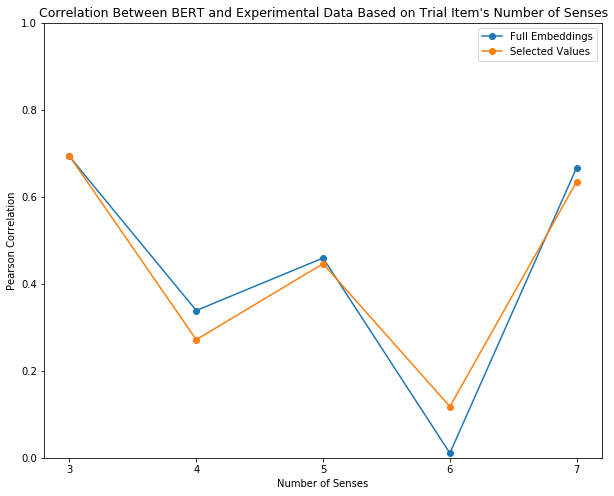

In [146]:
plt.figure(figsize = (10, 8))
plt.plot(range(3, 8),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_full') for i in range(3, 8)], 
         marker = 'o', label = 'Full Embeddings')
plt.plot(range(3, 8),
         [containing_query(all_trials, 'num_senses', [i], matrices, bert_key = 'bert_selected') for i in range(3, 8)],
         marker = 'o', label = 'Selected Values')
plt.xlabel("Number of Senses")
plt.ylabel("Pearson Correlation")
plt.xticks(np.arange(3, 8))
plt.title("Correlation Between BERT and Experimental Data Based on Trial Item's Number of Senses", fontsize = 12.5)
plt.legend()
plt.ylim(0, 1)
plt.savefig('../../results/figures/num_senses_corr.png')

In [73]:
semcor_entropy = pd.read_csv('../data/expt_semcor_types.csv')
semcor_entropy.drop("Unnamed: 0", axis = 1, inplace = True)
semcor_entropy['lemma'] = semcor_entropy['Lemma'].apply(lambda l: l.replace('.', '_'))
semcor_entropy.drop('Lemma', axis = 1, inplace = True)
all_entropy = all_trials.merge(semcor_entropy, on = 'lemma')

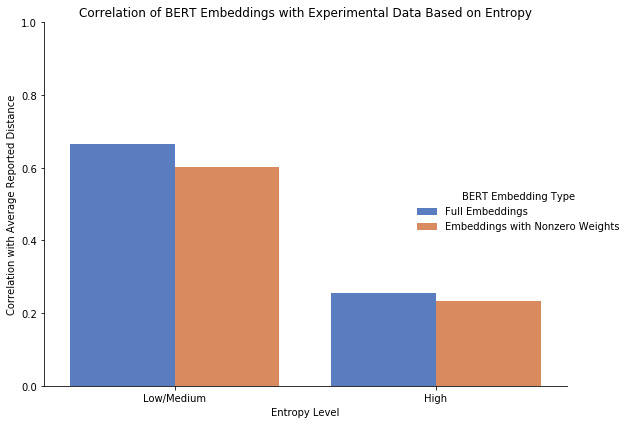

In [74]:
entropy_results = []
for e in ['bert_full', 'bert_selected']:
    if e == 'bert_full':
        legend_val = "Full Embeddings"
    else:
        legend_val = "Embeddings with Nonzero Weights"

    for b in [(0, 1.45), (1.45, 2.5)]:
        corr_for_ent = range_query(all_entropy, 'entropy', b[0], b[1], matrices, bert_key = e)
        if b[0] == 0:
            ent_level = 'Low/Medium'
        else:
            ent_level = 'High'
        entropy_results.append({"Entropy Level": ent_level, 'BERT Embedding Type': legend_val,
                                    "Correlation with Average Reported Distance": corr_for_ent})
entropy_results = pd.DataFrame(entropy_results)
sns.catplot(x="Entropy Level", y="Correlation with Average Reported Distance", hue="BERT Embedding Type", data=entropy_results,
                height=6, kind="bar", palette="muted")
plt.title("Correlation of BERT Embeddings with Experimental Data Based on Entropy")
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('../../results/figures/entropy_corr.png')

## Comparing Experimental Data with Confusion Matrices

In [130]:
with open('../data/test_confusion_matrices.json', 'r') as f:
    confusion_mtx = json.load(f)

In [131]:
for w in matrices:
    if w in confusion_mtx:
        matrices[w]['confusion'] = confusion_mtx[w]

In [132]:
def mtx_correlation(m1, m2, method = 'spearman', randomize_m1_labels = False, confusion = False): 
    #m1 and m2 are lists of distance matrices, spearman or pearson correlation
    #assert len(m1) == len(m2)
    if confusion:
        return stats.spearmanr(m1, m2)[0]
    else:
        flat_m1 = []
        for i in range(len(m1)):
            #OpTimiZAtIoNS
            ut_m1 = m1[i][np.triu_indices(m1[i].shape[0], k = 1)]
            if randomize_m1_labels:
                np.random.shuffle(ut_m1)
            flat_m1 += ut_m1.tolist()
        flat_m2 = []
        for i in range(len(m2)):
            ut_m2 = m2[i][np.triu_indices(m2[i].shape[0], k = 1)]
            flat_m2 += ut_m2.tolist()
        if method == 'spearman':
            return stats.spearmanr(flat_m1, flat_m2)[0]
        if method == 'pearson':
            return stats.pearsonr(flat_m1, flat_m2)[0]


In [133]:
flatten = lambda l: [item for sublist in l for item in sublist]

test_human_avg = [flatten((1 - matrices[w]['expt']).tolist()) for w in test_repeat_words]
conf = [flatten(matrices[w]['confusion']) for w in test_repeat_words]
print("Spearman Correlation between Human Data and Confusion Matrices",
      stats.spearmanr(flatten(test_human_avg), flatten(conf)))

Spearman Correlation between Human Data and Confusion Matrices SpearmanrResult(correlation=0.628775736740911, pvalue=1.8642698726752398e-50)


In [139]:
def range_query(df, value, low, high, dist_mtx_dict, bert_key = 'bert'):
    #Inclusive of low and high
    words_with_crit = df[(df[value] >= low) & (df[value] <= high)]['lemma'].unique()
    data_for_words = {w : dist_mtx_dict[w] for w in words_with_crit}
    if bert_key == 'confusion':
        expt_data = [(1 - data_for_words[w]['expt']).tolist() for w in data_for_words]
        conf_matrices = [data_for_words[w][bert_key] for w in data_for_words]

        return stats.spearmanr(flatten(flatten(expt_data)), flatten(flatten(conf_matrices)))[0]

    return mtx_correlation([data_for_words[w]['expt'] for w in data_for_words],
                          [data_for_words[w][bert_key] for w in data_for_words])[0]


In [135]:
test_rep_matrices = {k:v for k,v in matrices.items() if k in test_repeat_words}
test_rep_trials = all_trials[all_trials['trialType'].isin(['test', 'repeat'])]
for p in ['n', 'v']:
    print(p, "Correlation with Average Reported Distance",
          containing_query(test_rep_trials, 'pos', [p], test_rep_matrices, bert_key = 'confusion'))


n Correlation with Average Reported Distance 0.6453700758312424
v Correlation with Average Reported Distance 0.600027725508347


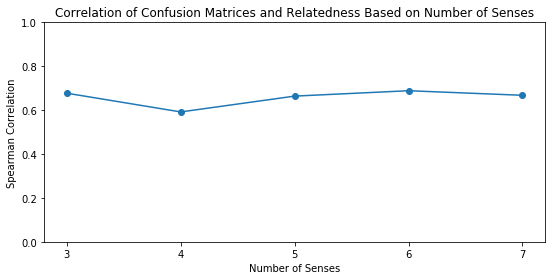

In [81]:
plt.figure(figsize = (8, 4))
plt.plot(range(3, 8),
         [containing_query(test_rep_trials, 'num_senses', [i],
                           test_rep_matrices, bert_key = 'confusion') for i in range(3, 8)], marker = 'o')
plt.xlabel("Number of Senses")
plt.ylabel("Spearman Correlation")
plt.title("Correlation of Confusion Matrices and Relatedness Based on Number of Senses")
plt.ylim(0, 1)
plt.xticks(np.arange(3, 8))
plt.tight_layout()
plt.savefig('../../results/figures/conf_num_senses.png')

In [100]:
test_rep_entropy = all_entropy[all_entropy['trialType'].isin(['test', 'repeat'])]

print("Correlation for med/low entropy words", range_query(test_rep_entropy, 'entropy', 0, 1.45,
                                                       test_rep_matrices, bert_key = 'confusion'))

Correlation for med/low entropy words 0.7738542661103431


In [101]:
print("Correlation for high entropy words", range_query(test_rep_entropy, 'entropy', 1.45, 2,
                                                       test_rep_matrices, bert_key = 'confusion'))

Correlation for high entropy words 0.5173360234917262
